# Count rate filtered correlation

The background in the fluorescence intensity affects the computed fluorescence correlation curves. To mitigate the effect of the background
on the correlation curves, low count rate regions in a photon stream can be discriminated before correlation.

The example below illustrates a correlation analysis for a single molecule FRET experiments to illustrate how to discriminate low
count rate regions in a photon stream for computing correlation functions of background filtered data.

Note, in the single-molecule example data the background has a significant contribution to the correlation functions. In the example a sliding time-window
(TW) is used to select regions in the photon stream with less than a certain amount of photons that are discriminated.

Such a filter can be used to remove the background in a single-molecule experiment that decreased the correlation amplitude.


In [1]:
# 1. Import all required libraries
import numpy as np
import matplotlib.pylab as plt
import tttrlib

## Unfiltered correlation

### Loading the data

In [2]:
# First, we do a normal correlation where all unfiltered data is correlated.
# For that, we first read the data into a TTTR container.
data = tttrlib.TTTR('./SingleMolecule/LP-344-525+7.5uM-UP-344-525_2/m000.spc', 'SPC-130')

In [3]:
# We use a dictionary that contains the most relevant parameters for the correlation algorithm, i.e., the number of bins, ``n_bins``, and the number
# of coarsening steps, ``n_casc``, as we are going to reuse these parameters later. ``n_bins`` and ``n_casc`` define the settings of the multi-tau correlation steps.
# If ``make_fine`` is set to false the micro time is not used for correlation.
settings = {
    "n_bins": 3,
    "n_casc": 27,
    "make_fine": False
}

### Correlating the data

In [4]:
# In the TTTR data the channel number 0 and 8 correspond to the green detectors. Here, ([0], [8]) is a correlation of the photons 
# in the channel [0] and the photons in channel [8].
corr_channels_green = ([0], [8])  # green detectors
correlator_green = tttrlib.Correlator(
    tttr=data,
    channels=corr_channels_green,
    **settings
)

corr_channels_red = ([1], [9])  # red detectors
correlator_red = tttrlib.Correlator(
    tttr=data,
    channels=corr_channels_red,
    **settings
)

In [5]:
# Now, we compute the green-red cross correlation. 
# Thus, our input for the correlator is ([0, 8], [1, 9]).
# This means, that all photons in the green channels [0, 8] are correlated to the photons in the red channel [1, 9].
channels_green_red = ([8, 0], [1, 9])
correlator_green_red = tttrlib.Correlator(
    tttr=data,
    channels=channels_green_red,
    **settings
)

### Plotting the unfiltered correlation

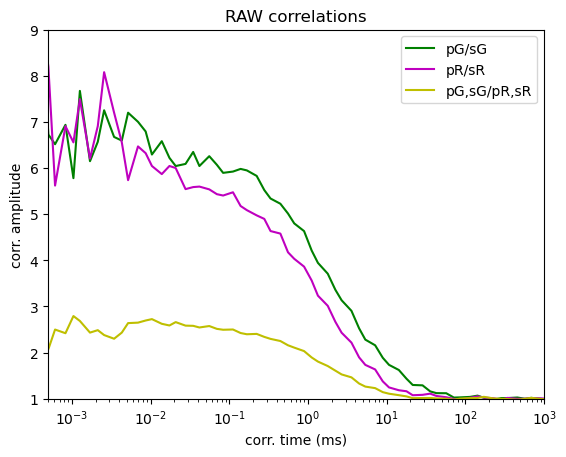

In [7]:
# Note: The x-axis (time axis) is multiplied with 1000 bring it to the common unit of millisecond
plt.semilogx(correlator_green.x_axis * 1000.0,correlator_green.correlation, label="pG/sG", color="g")
plt.semilogx(correlator_red.x_axis * 1000.0, correlator_red.correlation, label="pR/sR", color="m")
plt.semilogx(correlator_green_red.x_axis * 1000.0, correlator_green_red.correlation, label="pG,sG/pR,sR", color="y")
plt.xlabel('corr. time (ms)')
plt.ylabel('corr. amplitude')

plt.title('RAW correlations')
plt.xlim(5e-4, 1000)
plt.ylim(0.99, 9)
plt.legend()


## Filtered correlation

### Defining the filter

To reduce the contribution of scattered light on the correlation we select regions in the TTTR stream that have a minimum count rate. Here, we select regions with
at least 60 photons in time windows of 10 ms. Part of the photon stream is selected either by creating a list of indices that
refer to TTTR events. These indices are used to create a new TTTR object by slicing the original TTTR object. Below two options to create such a selection are illustrated.

In [8]:
filter_options = {
    'n_ph_max': 60,
    'time_window': 10.0e-3,  # = 10 ms (macro_time_resolution is in seconds)
    'invert': True  # set invert to True to select TW with more than 60 ph
}


In [9]:
# A selection can be made using the function ``selection_by_count_rate`` or using the method ``get_selection_by_count_rate``.
# Alternatively, a new TTTR object can be created directly using the filter options and the ``get_tttr_by_count_rate`` method of a TTTR object.

selection_idx = tttrlib.selection_by_count_rate(
        time=data.macro_times,
        macro_time_calibration=data.header.macro_time_resolution,
        **filter_options
    )

# OR:
#selection_idx = data.get_selection_by_count_rate(**filter_options)

tttr_selection = data[selection_idx]
tttr_selection = data.get_tttr_by_count_rate(**filter_options)


### Compute the correlation

In [10]:
# Next, we computed the count rate filtered correlations.
correlator_green_filtered = tttrlib.Correlator(
    channels=corr_channels_green,
    tttr=tttr_selection,
    **settings
)
correlator_red_filtered = tttrlib.Correlator(
    channels=corr_channels_red,
    tttr=tttr_selection,
    **settings
)
correlator_green_red_filtered = tttrlib.Correlator(
    channels=channels_green_red,
    tttr=tttr_selection,
    **settings
)

### Plotting the filtered correlation

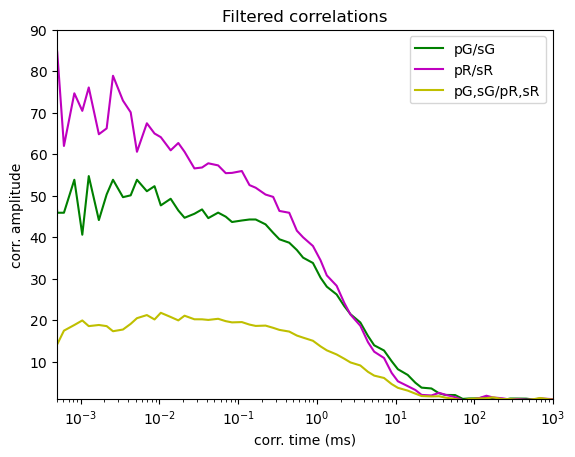

In [12]:
# The correlation amplitudes of the correlation curves for data with discriminated background is considerably higher 
# as seen in the plots of the raw and unfiltered correlations.

# Note: The x-axis (time axis) is multiplied with 1000 bring it to the common unit of millisecond
plt.semilogx(correlator_green_filtered.x_axis * 1000.0,correlator_green_filtered.correlation, label="pG/sG", color="g")
plt.semilogx(correlator_red_filtered.x_axis * 1000.0, correlator_red_filtered.correlation, label="pR/sR", color="m")
plt.semilogx(correlator_green_red_filtered.x_axis * 1000.0, correlator_green_red_filtered.correlation, label="pG,sG/pR,sR", color="y")
plt.xlabel('corr. time (ms)')
plt.ylabel('corr. amplitude')

plt.title('Filtered correlations')
plt.xlim(5e-4, 1000)
plt.ylim(0.99, 90)
plt.legend()


In [13]:
# Save data to txt file for plotting
time_axis = correlator_green.x_axis * 1000.0
time_axis_crfiltered = correlator_green_filtered.x_axis * 1000.0
filename_raw = 'results_unfiltered.txt'
np.savetxt(
    filename_raw,
    np.vstack(
        [
            time_axis,
            correlator_green.correlation,
            correlator_red.correlation,
            correlator_green_red.correlation
        ]
    ).T,
    delimiter='\t'
)

filename_filtered = 'results_filtered.txt'
np.savetxt(
    filename_filtered,
    np.vstack(
        [
            time_axis,
            correlator_green_filtered.correlation,
            correlator_red_filtered.correlation,
            correlator_green_red_filtered.correlation
        ]
    ).T,
    delimiter='\t'
)

